## Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras,
яка буде класифікувати товари із датасету fasion_mnist. https://www.tensorflow.org/datasets/catalog/fashion_mnist?hl=ru

Вам належить запропонувати свою власну архітектуру мережі.
Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%.
Точність вашої моделі повинна бути не нижчою за цей показник.
Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

- кількість шарів;
- кількість нейронів;
- функції активації;
- кількість епох;
- розмір батчу;
- вибір оптимізатора;
- різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

Рішення оформіть у вигляді окремого ноутбука.

In [73]:
import os
# Вимикаємо використання OneDNN у TensorFlow для усунення можливих помилок або покращення сумісності.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Імпортуємо бібліотеку TensorFlow та її високорівневий API Keras.
import tensorflow as tf

# Імпортуємо допоміжні бібліотеки для роботи з масивами та візуалізації.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import regularizers
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D, RandomFlip, RandomRotation, RandomZoom
from keras.optimizers import Adam, AdamW, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, EarlyStopping
from keras.datasets import fashion_mnist

# Виводимо версію TensorFlow для перевірки.
print(tf.__version__)

2.18.0


In [ ]:
# Завантажуємо набір даних Fashion MNIST.
fashion_mnist = tf.keras.datasets.fashion_mnist

# Завантажуємо тренувальні та тестові зображення і мітки.
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# train_images - зображення для тренування
# train_labels - мітки для тренувальних зображень
# test_images - зображення для тестування
# test_labels - мітки для тестових зображень

# Зображення є масивами NumPy розміру 28x28, з значеннями пікселів у діапазоні від 0 до 255.
# Мітки є масивом цілих чисел у діапазоні від 0 до 9.
# Вони відповідають класу одягу, який представляє зображення.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Кожне зображення відповідає певній мітці класу.
# Оскільки імена класів не включені в сам набір даних, ми збережемо їх у списку,
# щоб пізніше використовувати для візуалізації результатів.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
train_images.shape
# У навчальному наборі 60 000 зображень, кожне з яких представлене як 28x28 пікселів.

(60000, 28, 28)

In [ ]:
# В навчальному наборі є 60 000 міток, кожна з яких відповідає одному з зображень у тренувальному наборі.
len(train_labels)

60000

In [ ]:
train_labels
# Кожна мітка є цілим числом від 0 до 9.
# Ці числа відповідають класам одягу, який зображено на кожному зображенні в тренувальному наборі даних.

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
# В тестовому наборі міститься 10 000 зображень.
# Кожне зображення представлено у вигляді масиву розміром 28x28 пікселів.
test_images.shape

(10000, 28, 28)

In [ ]:
# Тестовий набір містить 10 000 міток, які відповідають класам зображень.
len(test_labels)

10000

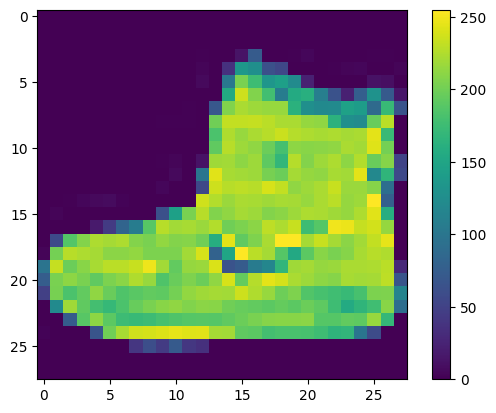

In [ ]:
# Відображаємо перше зображення з тренувального набору
plt.figure()
plt.imshow(train_images[0])  # Візуалізуємо зображення
plt.colorbar()  # Додаємо шкалу кольорів для кращого розуміння значень пікселів
plt.grid(False)  # Вимикаємо сітку для чистішого відображення
plt.show()  # Показуємо зображення

# Дані потрібно попередньо обробити перед навчанням нейронної мережі.
# Якщо подивитися на перше зображення в тренувальному наборі,
# можна побачити, що значення пікселів знаходяться в діапазоні від 0 до 255.

In [ ]:
# Масштабуємо значення пікселів у діапазон від 0 до 1, поділивши кожен елемент масиву на 255.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Важливо, щоб як тренувальна, так і тестова вибірки були попередньо оброблені однаково.
# Це допоможе моделі швидше навчатися та покращить її точність.

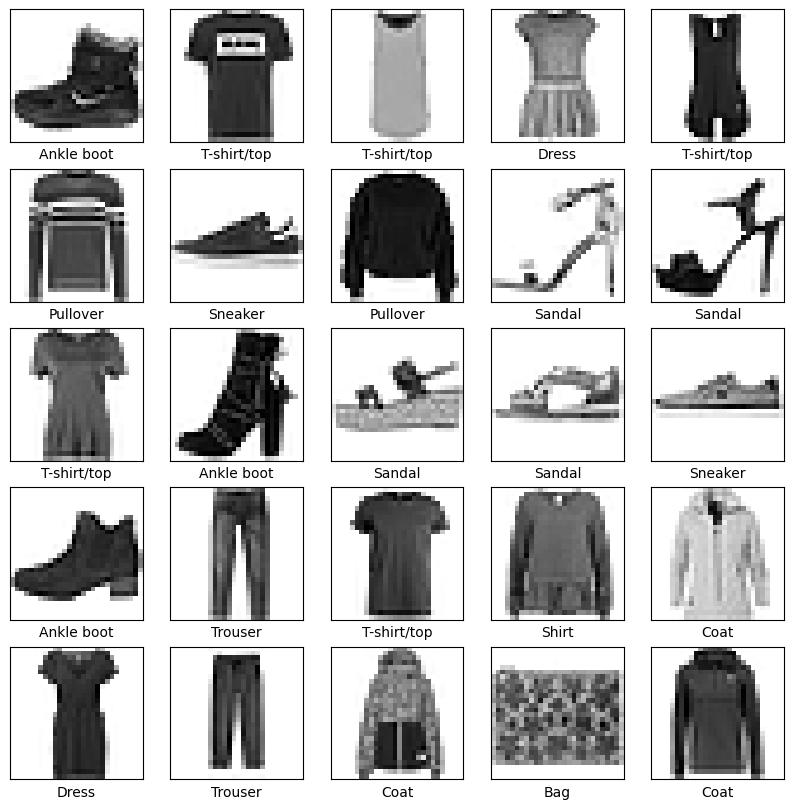

In [ ]:
# Переконаємося, що дані мають правильний формат перед тренуванням нейронної мережі.
# Відобразимо перші 25 зображень з навчального набору даних та підпишемо їх класами.

plt.figure(figsize=(10, 10))  # Встановлюємо розмір фігури для візуалізації

for i in range(25):
    plt.subplot(5, 5, i + 1)  # Створюємо 5x5 сітку для зображень
    plt.xticks([])  # Вимикаємо підписи по осі X
    plt.yticks([])  # Вимикаємо підписи по осі Y
    plt.grid(False)  # Відключаємо сітку
    plt.imshow(train_images[i], cmap=plt.cm.binary)  # Відображаємо зображення в чорно-білому форматі
    plt.xlabel(class_names[train_labels[i]])  # Додаємо підпис класу під зображенням

plt.show()  # Відображаємо підготовлену візуалізацію

In [ ]:
# Створення списку для збереження результатів
models_results = []

## Model 1 (Побудова)

In [ ]:
# Створюємо нейронну мережу, використовуючи модель `Sequential`
model = tf.keras.Sequential([
    # Перший шар `Flatten` перетворює зображення (28x28) у плоский вектор довжиною 784
    tf.keras.Input(shape=(28, 28)),  # Додаємо вхідний шар
    tf.keras.layers.Flatten(),       # Перетворюємо 2D-матрицю в 1D-вектор

    # Повністю зв'язаний (Dense) шар із 128 нейронами та функцією активації ReLU
    tf.keras.layers.Dense(128, activation='relu'),

    # Останній шар має 10 виходів (відповідає 10 класам), без функції активації,
    # оскільки на виході будуть логіти (сирі оцінки ймовірності)
    tf.keras.layers.Dense(10)
])

# Перший шар `Flatten` лише змінює формат зображення з 2D (28x28) у 1D (784 пікселів).
# Він не має параметрів для навчання, а лише переформатовує вхідні дані.

# Після шару Flatten йдуть два Dense-шари:
# - Перший має 128 нейронів із функцією активації ReLU.
# - Останній містить 10 нейронів, які відповідають 10 класам одягу.
# Кожен нейрон останнього шару повертає логіт — числову оцінку приналежності до певного класу.

In [ ]:
# Компіляція моделі перед тренуванням
model.compile(
    optimizer='adam',  # Оптимізатор, що оновлює ваги моделі
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Функція втрат для багатокласової класифікації
    metrics=['accuracy']  # Моніторинг точності під час навчання
)

In [ ]:
# Навчання моделі
history = model.fit(
    # Вхідні зображення для навчання.
    # Це набір даних, що складається з 60,000 зображень, кожне розміром 28x28 пікселів.
    train_images,
    # Відповідні мітки для кожного зображення з `train_images`.
    # Це набір із 60,000 чисел, що вказують клас (наприклад, "светр", "спідниця" тощо).
    train_labels,
    # Кількість етапів (епох), на яких модель буде навчатися.
    # За один етап модель проходить через весь набір даних.
    # Встановлено 10 епох, що означає, що модель буде навчатися 10 разів на всіх даних.
    epochs=10,
    # Додаємо валідаційні дані.
    validation_data=(test_images, test_labels)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7815 - loss: 0.6305 - val_accuracy: 0.8506 - val_loss: 0.4189
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8625 - loss: 0.3796 - val_accuracy: 0.8632 - val_loss: 0.3782
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8758 - loss: 0.3391 - val_accuracy: 0.8744 - val_loss: 0.3574
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8873 - loss: 0.3075 - val_accuracy: 0.8715 - val_loss: 0.3550
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8927 - loss: 0.2923 - val_accuracy: 0.8739 - val_loss: 0.3625
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8960 - loss: 0.2786 - val_accuracy: 0.8788 - val_loss: 0.3392
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9035 - loss: 0.2630 - val_accuracy: 0.8807 - val_loss: 0.3339
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9047 - loss: 0.25

In [ ]:
# Оцінка точності моделі на тестовому наборі даних
# Після того, як модель навчена, ми можемо оцінити її продуктивність на нових, раніше не бачених даних — в тестовому наборі.
# Для цього використовуємо метод `evaluate`, який розрахує функцію втрат і точність на тестових зображеннях і мітках.

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
# `test_images` — це набір тестових зображень (10 000 зображень 28x28 пікселів).
# `test_labels` — це відповідні мітки для цих зображень.
# `verbose=2` — це параметр, що визначає рівень виведення під час оцінки моделі (verbose=2 виведе прогрес виконання без зайвих деталей).

# Після виконання evaluate ми отримаємо дві величини:
# - test_loss — це значення функції втрат на тестових даних. Менше значення функції втрат вказує на те, що модель працює краще.
# - test_acc — це точність моделі на тестових даних (відсоток правильних прогнозів).

# Виводимо результат:
print('\nTest accuracy:', test_acc)
# Виводиться точність на тестовому наборі. Це буде число між 0 і 1, що вказує на відсоток правильних прогнозів моделі.

313/313 - 1s - 2ms/step - accuracy: 0.8812 - loss: 0.3314

Test accuracy: 0.8812000155448914


In [ ]:
def plot_accuracy(history):
    """
    Функція для побудови графіку точності навчання та валідації.
    На графіку також позначається точка з найкращою точністю на етапі валідації та навчання.

    Параметри:
    history (History): Об'єкт історії навчання, який містить дані про точність та втрати за кожну епоху.
    """
    # Отримуємо найкращі значення
    best_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_train_acc = history.history['accuracy'][best_epoch]

    # Побудова графіку
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Додавання точки з найкращою валідною точністю
    plt.scatter(best_epoch, best_val_acc, color='red', marker='o', label=f'Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch+1})')
    plt.scatter(best_epoch, best_train_acc, color='blue', marker='o', label=f'Best Train Acc: {best_train_acc:.4f} (Epoch {best_epoch+1})')

    # Налаштування осей
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    plt.grid(True)
    plt.show()

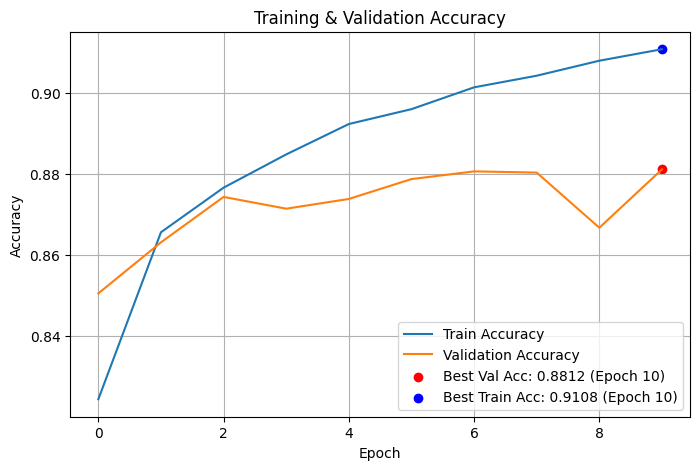

In [ ]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху,
# отримані після навчання моделі.
plot_accuracy(history)

In [ ]:
# зберігає модель у файл формату .keras
# дозволяє зберігати модель для подальшого використання, навіть після того, як сесія тренування завершена.
model.save('model_1.keras')

# Зберігаємо модель і точність у список
models_results.append({
    'model_name': 'model_1',
    'model_name_file': 'model_1.keras',
    'accuracy': test_acc,
    'model': model
})

# Модель з найвищою точністю
best_model = max(models_results, key=lambda x: x['accuracy'])

# Виводимо найкращу модель та її точність
print(f"The best model is: {best_model['model_name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

The best model is: model_1
Accuracy: 0.8812


## Model 2 (Побудова)

In [ ]:
# Зміна параметрів

# Створення покращеної моделі
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation='softmax')
])

# Компiляцiя моделі
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Навчання моделі
history = model.fit(
    train_images,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_data=(test_images, test_labels)
)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7358 - loss: 0.7876 - val_accuracy: 0.8421 - val_loss: 0.4397
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8348 - loss: 0.4625 - val_accuracy: 0.8556 - val_loss: 0.3991
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8500 - loss: 0.4155 - val_accuracy: 0.8575 - val_loss: 0.3936
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8567 - loss: 0.3947 - val_accuracy: 0.8603 - val_loss: 0.3827
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8612 - loss: 0.3795 - val_accuracy: 0.8636 - val_loss: 0.3795
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8647 - loss: 0.3723 - val_accuracy: 0.8685 - val_loss: 0.3692
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8677 - loss: 0.3609 - val_accuracy: 0.8662 - val_loss: 0.3727
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8721 - loss: 0.3475 - val_accur

In [ ]:
# Оцінка точності
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 1s - 3ms/step - accuracy: 0.8750 - loss: 0.3412

Test accuracy: 0.8750


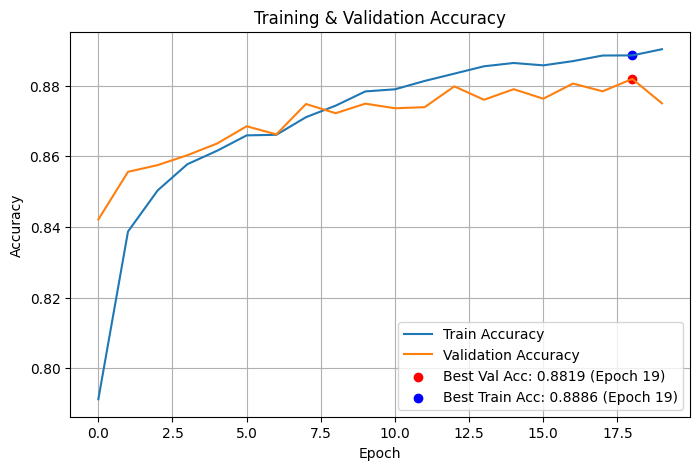

In [ ]:
# Викликаємо функцію для побудови графіку точності на основі історії навчання.
# Параметр 'history' містить дані про точність та втрати за кожну епоху,
# отримані після навчання моделі.
plot_accuracy(history)

In [ ]:
# зберігає модель у файл формату .keras
# дозволяє зберігати модель для подальшого використання, навіть після того, як сесія тренування завершена.
model.save('model_2.keras')

# Зберігаємо модель і точність у список
models_results.append({
    'model_name': 'model_2',
    'model_name_file': 'model_2.keras',
    'accuracy': test_acc,
    'model': model
})

# Модель з найвищою точністю
best_model = max(models_results, key=lambda x: x['accuracy'])

# Виводимо найкращу модель та її точність
print(f"The best model is: {best_model['model_name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

The best model is: model_1
Accuracy: 0.8812


## Model 3 (Побудова)

In [ ]:
# Зміна параметрів

# Створення покращеної моделі
model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Компiляцiя моделі
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Додаємо ранню зупинку
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Навчання моделі
history = model.fit(
    train_images,
    train_labels,
    epochs=40,
    batch_size=64,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7206 - loss: 0.7795 - val_accuracy: 0.8434 - val_loss: 0.4277
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8471 - loss: 0.4182 - val_accuracy: 0.8559 - val_loss: 0.3888
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8607 - loss: 0.3764 - val_accuracy: 0.8673 - val_loss: 0.3720
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8695 - loss: 0.3521 - val_accuracy: 0.8713 - val_loss: 0.3548
Epoch 5/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8760 - loss: 0.3354 - val_accuracy: 0.8720 - val_loss: 0.3495
Epoch 6/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8825 - loss: 0.3162 - val_accuracy: 0.8776 - val_loss: 0.3342
Epoch 7/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8857 - loss: 0.3054 - val_accuracy: 0.8790 - val_loss: 0.3350
Epoch 8/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8880 - loss: 0.2987 - 

In [ ]:
# Оцінка точності
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 1s - 3ms/step - accuracy: 0.8957 - loss: 0.2977

Test accuracy: 0.8957


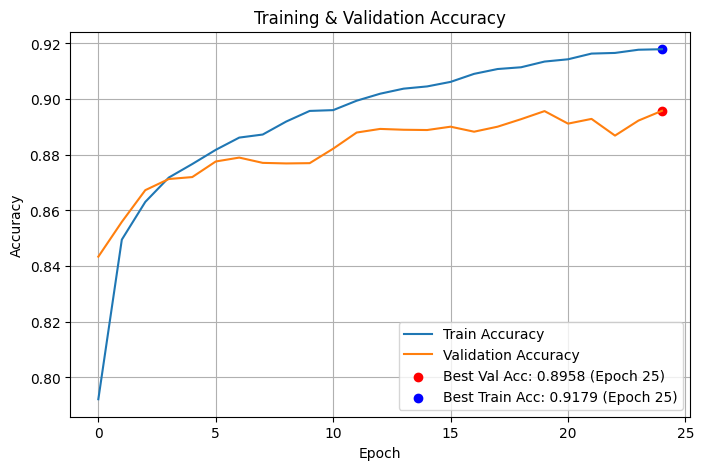

In [ ]:
plot_accuracy(history)

In [ ]:
# зберігає модель у файл формату .keras
# дозволяє зберігати модель для подальшого використання, навіть після того, як сесія тренування завершена.
model.save('model_3.keras')

# Зберігаємо модель і точність у список
models_results.append({
    'model_name': 'model_3',
    'model_name_file': 'model_3.keras',
    'accuracy': test_acc,
    'model': model
})

# Модель з найвищою точністю
best_model = max(models_results, key=lambda x: x['accuracy'])

# Виводимо найкращу модель та її точність
print(f"The best model is: {best_model['model_name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

The best model is: model_3
Accuracy: 0.8957


## Model 4 (Побудова)

In [ ]:
# Зміна параметрів

# Створення покращеної моделі
model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(10, activation='softmax')
])

# Компiляцiя моделі
optimizer = RMSprop(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Додаємо ReduceLROnPlateau + EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Навчання моделі
history = model.fit(
    train_images,
    train_labels,
    epochs=25,
    batch_size=64,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7228 - loss: 1.0902 - val_accuracy: 0.8374 - val_loss: 0.6455 - learning_rate: 5.0000e-04
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8288 - loss: 0.6582 - val_accuracy: 0.8192 - val_loss: 0.6204 - learning_rate: 5.0000e-04
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8422 - loss: 0.5794 - val_accuracy: 0.8256 - val_loss: 0.5930 - learning_rate: 5.0000e-04
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8520 - loss: 0.5261 - val_accuracy: 0.8551 - val_loss: 0.4903 - learning_rate: 5.0000e-04
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8557 - loss: 0.4952 - val_accuracy: 0.8549 - val_loss: 0.4812 - learning_rate: 5.0000e-04
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8608 - loss: 0.4755 - val_accuracy: 0.8570 - val_loss: 0.4638 - learning_rate: 5.0000e-04
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accurac

In [ ]:
# Оцінка точності
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 1s - 3ms/step - accuracy: 0.8874 - loss: 0.3698

Test accuracy: 0.8874


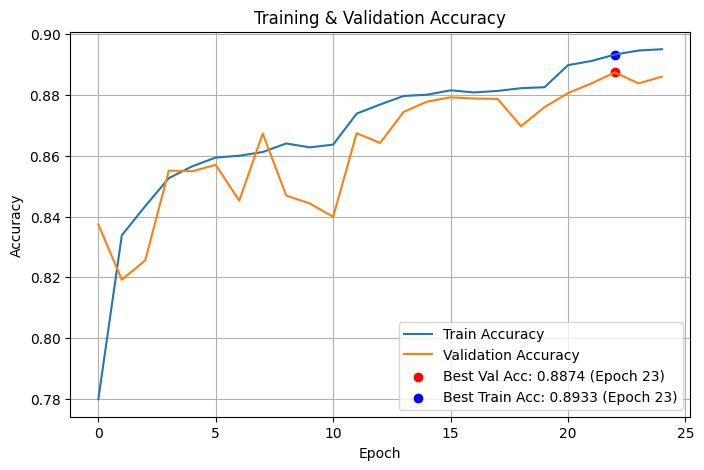

In [ ]:
plot_accuracy(history)

In [ ]:
# зберігає модель у файл формату .keras
# дозволяє зберігати модель для подальшого використання, навіть після того, як сесія тренування завершена.
model.save('model_4.keras')

# Зберігаємо модель і точність у список
models_results.append({
    'model_name': 'model_4',
    'model_name_file': 'model_4.keras',
    'accuracy': test_acc,
    'model': model
})

# Модель з найвищою точністю
best_model = max(models_results, key=lambda x: x['accuracy'])

# Виводимо найкращу модель та її точність
print(f"The best model is: {best_model['model_name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

The best model is: model_3
Accuracy: 0.8957


## Model 5 (Побудова)

In [ ]:
# Зміна параметрів

# Створення покращеної моделі
model = Sequential([
    Input(shape=(28, 28)),  # Вхідний шар для зображень 28x28
    Flatten(),  # Перетворення 2D зображення в 1D

    # Перший прихований шар із покращеною регуляризацією
    Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    # Другий прихований шар
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),

    # Додатковий третій прихований шар
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.3),

    # Вихідний шар
    Dense(10, activation='softmax')
])

# Компiляцiя моделі
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Навчання моделі
history = model.fit(
    train_images,
    train_labels,
    epochs=60,
    batch_size=128,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3725 - loss: 3.0215 - val_accuracy: 0.7666 - val_loss: 1.7329 - learning_rate: 1.0000e-04
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6856 - loss: 1.9543 - val_accuracy: 0.8074 - val_loss: 1.5427 - learning_rate: 1.0000e-04
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7471 - loss: 1.7093 - val_accuracy: 0.8202 - val_loss: 1.4441 - learning_rate: 1.0000e-04
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7766 - loss: 1.5762 - val_accuracy: 0.8313 - val_loss: 1.3644 - learning_rate: 1.0000e-04
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7929 - loss: 1.4902 - val_accuracy: 0.8372 - val_loss: 1.2961 - learning_rate: 1.0000e-04
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8058 - loss: 1.3966 - val_accuracy: 0.8460 - val_loss: 1.2310 - learning_rate: 1.0000e-04
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step -

In [ ]:
# Оцінка точності
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 1s - 5ms/step - accuracy: 0.8814 - loss: 0.4963

Test accuracy: 0.8814


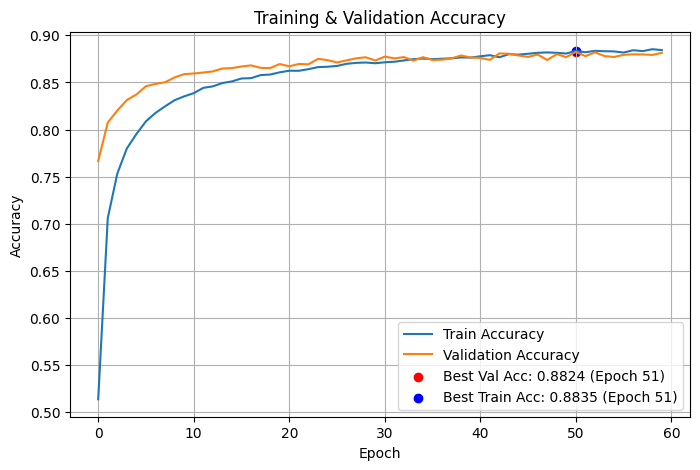

In [ ]:
plot_accuracy(history)

In [ ]:
# зберігає модель у файл формату .keras
# дозволяє зберігати модель для подальшого використання, навіть після того, як сесія тренування завершена.
model.save('model_5.keras')

# Зберігаємо модель і точність у список
models_results.append({
    'model_name': 'model_5',
    'model_name_file': 'model_5.keras',
    'accuracy': test_acc,
    'model': model
})

# Модель з найвищою точністю
best_model = max(models_results, key=lambda x: x['accuracy'])

# Виводимо найкращу модель та її точність
print(f"The best model is: {best_model['model_name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

The best model is: model_3
Accuracy: 0.8957


## Model 6 (Побудова, Найкраща)

In [ ]:
# Зміна параметрів
# Створення покращеної моделі

# Завантажуємо набір даних Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Додаємо додатковий вимір (канал), щоб адаптувати дані до Conv2D
# Також нормалізуємо зображення (перетворюємо значення пікселів у діапазон [0, 1])
train_images_conv2d = train_images[..., None] / 255.0
test_images_conv2d = test_images[..., None] / 255.0

# Аугментація даних: додає варіативність до зображень під час навчання
# Це допомагає зменшити перенавчання та покращити узагальнюючу здатність моделі
data_augmentation = Sequential([
    RandomFlip("horizontal"),   # Випадкове горизонтальне віддзеркалення
    RandomRotation(0.1),        # Випадковий поворот на 10%
    RandomZoom(0.1)             # Випадкове масштабування (збільшення або зменшення)
])

# Побудова згорткової нейромережі (CNN) для класифікації зображень
model = Sequential([

    # Блок аугментації (тільки для тренувальних даних)
    data_augmentation,

    # Перший згортковий шар
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # 32 фільтри, ядро 3x3, ReLU
    BatchNormalization(),  # Нормалізація партій (Batch Normalization)
    MaxPooling2D((2, 2)),  # Максимальне згортання 2x2

    # Другий згортковий шар
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # 64 фільтри, ядро 3x3, ReLU
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Перетворення у вектор
    Flatten(),

    # Повнозв'язний шар з 256 нейронами
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Випадкове вимикання 40% нейронів для запобігання перенавчанню

    # Ще один повнозв'язний шар з 128 нейронами
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Випадкове вимикання 30% нейронів

    # Вихідний шар: 10 нейронів (класів), softmax для ймовірностей
    Dense(10, activation='softmax')
])

# Використовуємо оптимізатор AdamW (поліпшена версія Adam з ваговою регуляризацією)
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)

# Компіляція моделі
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Крос-ентропійна функція втрат для категорійних міток
    metrics=['accuracy']  # Оцінка точності моделі
)

# Callbacks для покращення навчання моделі
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)  # Зменшує LR при зупинці покращення
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Зупиняє навчання, якщо не покращується

# Навчання моделі
history = model.fit(
    train_images_conv2d,
    train_labels,
    epochs=50,  # Макс. кількість епох
    batch_size=128,  # Розмір батчу
    validation_data=(test_images_conv2d, test_labels),  # Валідаційні дані
    callbacks=[reduce_lr, early_stopping]  # Використання callback-ів
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 125s 256ms/step - accuracy: 0.6805 - loss: 0.9091 - val_accuracy: 0.6738 - val_loss: 0.8255 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 242ms/step - accuracy: 0.8206 - loss: 0.5006 - val_accuracy: 0.8294 - val_loss: 0.4641 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 237ms/step - accuracy: 0.8412 - loss: 0.4361 - val_accuracy: 0.8135 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 237ms/step - accuracy: 0.8553 - loss: 0.4026 - val_accuracy: 0.8518 - val_loss: 0.4094 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 239ms/step - accuracy: 0.8637 - loss: 0.3746 - val_accuracy: 0.8451 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 233ms/step - accuracy: 0.8691 - loss: 0.3610 - val_accuracy: 0.8685 - val_loss: 0.3539 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 235ms/step - accura

In [ ]:
# Оцінка моделі
test_loss, test_acc = model.evaluate(test_images_conv2d, test_labels)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9160 - loss: 0.2296
Test accuracy: 0.9220


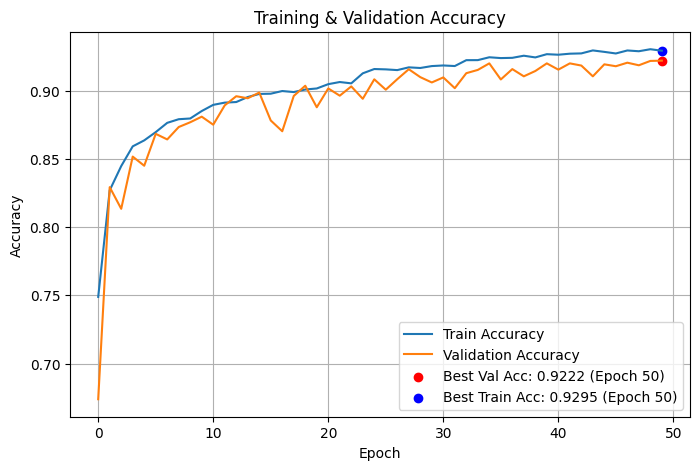

In [ ]:
plot_accuracy(history)

In [ ]:
# зберігає модель у файл формату .keras
# дозволяє зберігати модель для подальшого використання, навіть після того, як сесія тренування завершена.
model.save('model_6.keras')

# Зберігаємо модель і точність у список
models_results.append({
    'model_name': 'model_6',
    'model_name_file': 'model_6.keras',
    'accuracy': test_acc,
    'model': model
})

# Модель з найвищою точністю
best_model = max(models_results, key=lambda x: x['accuracy'])

# Виводимо найкращу модель та її точність
print(f"The best model is: {best_model['model_name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")

The best model is: model_6
Accuracy: 0.9220


## Перевірка найкращої моделі (Model 6 із аугментацією)

In [ ]:
model = next((item['model'] for item in models_results if item['model_name'] == 'model_6'), None)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,572,064 (9.81 MB)

 Trainable params: 857,034 (3.27 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,714,070 (6.54 MB)

In [ ]:
# Створюємо модель без аугментації для прогнозування
# Ми використовуємо `Sequential` для створення нової моделі, яка містить усі шари оригінальної моделі,
# за винятком першого шару (аугментації даних). Це потрібно, тому що аугментація застосовується лише
# під час навчання, а не під час прогнозування.
prediction_model = Sequential(model.layers[1:])  # Пропускаємо перший шар (аугментацію)

# Компілюємо нову модель
# Використовуємо той самий оптимізатор (`optimizer`), функцію втрат (`loss`) та метрики (`metrics`),
# які були використані для оригінальної моделі. Це забезпечує узгодженість між навчанням і прогнозуванням.
prediction_model.compile(
    optimizer=optimizer,  # Оптимізатор AdamW, який ви використовували для навчання
    loss='sparse_categorical_crossentropy',  # Функція втрат для категорійної класифікації
    metrics=['accuracy']  # Метрика для оцінки точності
)

# Отримуємо прогнози для тестових зображень
# Використовуємо метод `predict` для отримання ймовірностей кожного класу для тестових зображень.
# `test_images_conv2d` — це тестові зображення, які були попередньо оброблені (нормалізовані та
# перетворені у формат, який підходить для згорткових шарів (формат (28, 28, 1)).
predictions = prediction_model.predict(test_images_conv2d)

# Результат `predictions` — це масив, де кожен рядок відповідає одному зображенню,
# а кожен стовпець — ймовірності належності до одного з 10 класів (у Fashion MNIST).
# Наприклад, predictions[0] — це масив із 10 значень, які представляють ймовірності
# для першого зображення належати до кожного з класів.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


In [ ]:
# Замість того щоб виводити ймовірності для всіх класів, ми можемо подивитись на перше передбачення з predictions.
# Це передбачення містить 10 ймовірностей, кожна з яких відповідає ймовірності того, що зображення належить до певного класу.
# Тому давайте подивимось на ймовірності для першого зображення в тестовому наборі:

predictions[0]

array([2.1329704e-07, 1.5054676e-06, 9.0881578e-08, 2.0989326e-07,
       2.3567874e-07, 2.9326178e-04, 1.4577284e-07, 1.2264481e-03,
       3.8642631e-07, 9.9847752e-01], dtype=float32)

In [ ]:
# np.argmax(predictions[0]) повертає індекс класу з найвищою ймовірністю для першого зображення
# Таким чином, ми можемо визначити, до якого класу модель відносить це зображення:

predicted_class = np.argmax(predictions[0])

# Тепер можемо вивести сам індекс класу з найбільшою ймовірністю, що відповідає найбільш вірогідному класу:
print(f"Прогнозований клас для першого зображення: {predicted_class}")

Прогнозований клас для першого зображення: 9


In [ ]:
# Виводимо фактичну мітку для першого зображення в тестовому наборі:
print(f"Фактична мітка для першого зображення: {test_labels[0]}")

Фактична мітка для першого зображення: 9


In [ ]:
# Перетворюємо прогнози у мітки класів
predicted_labels = np.argmax(predictions, axis=1)

# Виводимо реальні мітки та прогнозовані мітки для порівняння
for i in range(10):
    print(f"Зображення {i}: Прогноз = {predicted_labels[i]}, Реальна мітка = {test_labels[i]}")

Зображення 0: Прогноз = 9, Реальна мітка = 9
Зображення 1: Прогноз = 2, Реальна мітка = 2
Зображення 2: Прогноз = 1, Реальна мітка = 1
Зображення 3: Прогноз = 1, Реальна мітка = 1
Зображення 4: Прогноз = 6, Реальна мітка = 6
Зображення 5: Прогноз = 1, Реальна мітка = 1
Зображення 6: Прогноз = 4, Реальна мітка = 4
Зображення 7: Прогноз = 6, Реальна мітка = 6
Зображення 8: Прогноз = 5, Реальна мітка = 5
Зображення 9: Прогноз = 7, Реальна мітка = 7


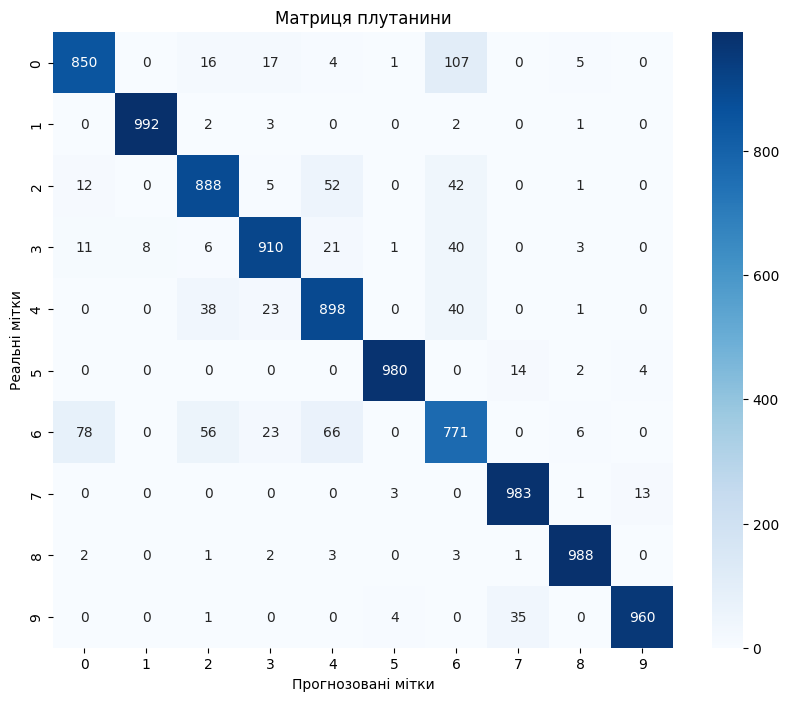

In [ ]:
# Створення матриці плутанини
# confusion_matrix приймає два аргументи:
# 1. test_labels: реальні мітки класів (правильні відповіді).
# 2. predicted_labels: прогнозовані мітки класів (результати роботи моделі).
# Результат — це матриця, де:
# - Рядки відповідають реальним міткам.
# - Стовпці відповідають прогнозованим міткам.
# - Значення в комірках показують кількість зображень, які належать до певного реального класу та були класифіковані як певний прогнозований клас.
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Візуалізація матриці плутанини
# Створюємо нове вікно для графіка з розміром 10x8 дюймів.
plt.figure(figsize=(10, 8))

# Використовуємо seaborn.heatmap для візуалізації матриці плутанини.
# Параметри:
# - conf_matrix: матриця плутанини, яку ми створили.
# - annot=True: додає числа в комірки матриці.
# - fmt='d': форматує числа як цілі (наприклад, 850, 10, тощо).
# - cmap='Blues': використовує синю кольорову схему для візуалізації.
# - xticklabels=range(10): підписи для стовпців (прогнозовані мітки) від 0 до 9.
# - yticklabels=range(10): підписи для рядків (реальні мітки) від 0 до 9.
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

# Додаємо підписи до осей:
# - Вісь X: "Прогнозовані мітки".
# - Вісь Y: "Реальні мітки".
plt.xlabel('Прогнозовані мітки')
plt.ylabel('Реальні мітки')

# Додаємо заголовок до графіка.
plt.title('Матриця плутанини')

# Відображаємо графік.
plt.show()

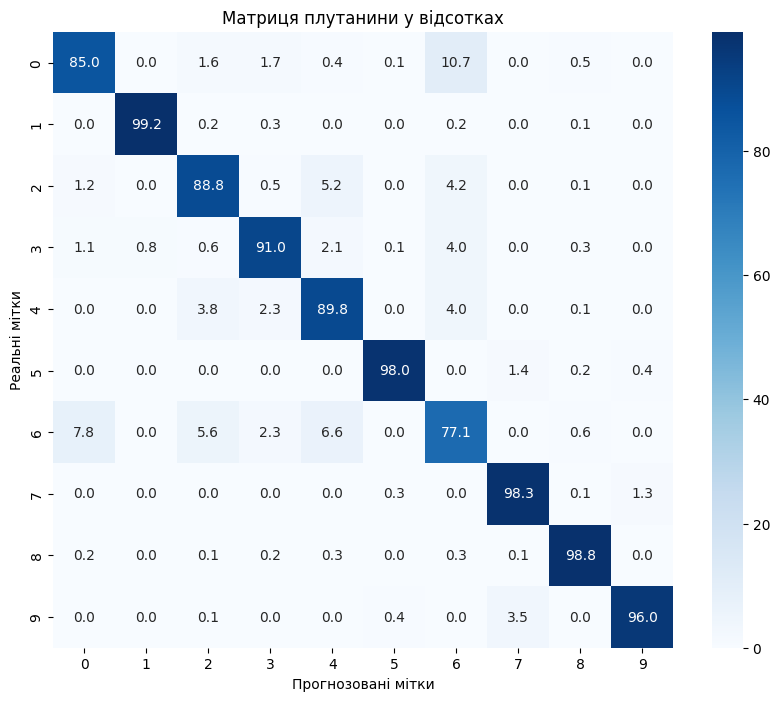

In [ ]:
# Створення матриці плутанини
# confusion_matrix приймає два аргументи:
# 1. test_labels: реальні мітки класів (правильні відповіді).
# 2. predicted_labels: прогнозовані мітки класів (результати роботи моделі).
# Результат — це матриця, де:
# - Рядки відповідають реальним міткам.
# - Стовпці відповідають прогнозованим міткам.
# - Значення в комірках показують кількість зображень, які належать до певного реального класу та були класифіковані як певний прогнозований клас.
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Нормалізація матриці плутанини у відсотках
# Для цього кожен елемент матриці ділиться на суму рядка (кількість зображень у реальному класі) і множиться на 100.
# Кроки:
# 1. conf_matrix.astype('float'): Перетворюємо матрицю у тип float, щоб уникнути цілочисельного ділення.
# 2. conf_matrix.sum(axis=1): Обчислюємо суму кожного рядка (кількість зображень у кожному реальному класі).
# 3. [:, np.newaxis]: Додаємо новий вимір для правильного ділення (перетворюємо вектор у стовпець).
# 4. * 100: Перетворюємо значення у відсотки.
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Візуалізація матриці плутанини у відсотках
# Створюємо нове вікно для графіка з розміром 10x8 дюймів.
plt.figure(figsize=(10, 8))

# Використовуємо seaborn.heatmap для візуалізації матриці плутанини.
# Параметри:
# - conf_matrix_percent: нормалізована матриця плутанини у відсотках.
# - annot=True: додає числа в комірки матриці.
# - fmt='.1f': форматує числа з одним знаком після коми (наприклад, 85.5, 10.0, тощо).
# - cmap='Blues': використовує синю кольорову схему для візуалізації.
# - xticklabels=range(10): підписи для стовпців (прогнозовані мітки) від 0 до 9.
# - yticklabels=range(10): підписи для рядків (реальні мітки) від 0 до 9.
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

# Додаємо підписи до осей:
# - Вісь X: "Прогнозовані мітки".
# - Вісь Y: "Реальні мітки".
plt.xlabel('Прогнозовані мітки')
plt.ylabel('Реальні мітки')

# Додаємо заголовок до графіка.
plt.title('Матриця плутанини у відсотках')

# Відображаємо графік.
plt.show()

## Перевірка Моделі #5 (Найкраща без аугментації)

In [ ]:
# Шукаємо модель 'model_5' та витягуємо значення ключа 'model'
model = next((item['model'] for item in models_results if item['model_name'] == 'model_5'), None)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 731,872 (2.79 MB)

 Trainable params: 243,658 (951.79 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 487,318 (1.86 MB)

In [ ]:
# Завантажуємо набір даних Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Масштабуємо значення пікселів у діапазон від 0 до 1, поділивши кожен елемент масиву на 255.
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
# Додавання шару Softmax для перетворення лінійних виходів (логітів) у ймовірності
# Шар Softmax застосовується до виходу моделі для того,
# щоб перетворити логіти (які можуть бути будь-якими числами) на ймовірності (числа від 0 до 1),
# які можна буде інтерпретувати як ймовірність належності до кожного класу.
# Логіти — це необроблені оцінки, які модель генерує перед тим, як застосувати softmax, щоб отримати інтерпретовані ймовірності.

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# Створюється нова модель `probability_model`, яка складається з оригінальної моделі `model`,
# за якою йде шар `Softmax`, що забезпечить перетворення логітів у ймовірності.

# Зробимо передбачення для тестового набору зображень
# Метод `predict` повертає ймовірності того, до якого класу належить кожне зображення.
predictions = probability_model.predict(test_images)
# `test_images` — це набір зображень для тестування (10 000 зображень), які модель ще не бачила.
# `predictions` містить ймовірності для кожного зображення відносно кожного з 10 класів (T-shirt, Trouser, Pullover і т.д.).

# Для кожного зображення predictions містить 10 значень — ймовірності того, що зображення належить кожному з класів.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Замість того щоб виводити ймовірності для всіх класів, ми можемо подивитись на перше передбачення з predictions.
# Це передбачення містить 10 ймовірностей, кожна з яких відповідає ймовірності того, що зображення належить до певного класу.
# Тому давайте подивимось на ймовірності для першого зображення в тестовому наборі:

predictions[0]

array([0.08544838, 0.08544964, 0.0854485 , 0.0854486 , 0.08544884,
       0.08550729, 0.08544863, 0.08615202, 0.08544949, 0.23019859],
      dtype=float32)

In [ ]:
# np.argmax(predictions[0]) повертає індекс класу з найвищою ймовірністю для першого зображення
# Таким чином, ми можемо визначити, до якого класу модель відносить це зображення:

predicted_class = np.argmax(predictions[0])

# Тепер можемо вивести сам індекс класу з найбільшою ймовірністю, що відповідає найбільш вірогідному класу:
print(f"Прогнозований клас для першого зображення: {predicted_class}")

Прогнозований клас для першого зображення: 9


In [ ]:
# Виводимо фактичну мітку для першого зображення в тестовому наборі:
print(f"Фактична мітка для першого зображення: {test_labels[0]}")

Фактична мітка для першого зображення: 9


In [ ]:
# Перетворюємо прогнози у мітки класів
predicted_labels = np.argmax(predictions, axis=1)

# Виводимо реальні мітки та прогнозовані мітки для порівняння
for i in range(10):
    print(f"Зображення {i}: Прогноз = {predicted_labels[i]}, Реальна мітка = {test_labels[i]}")

Зображення 0: Прогноз = 9, Реальна мітка = 9
Зображення 1: Прогноз = 2, Реальна мітка = 2
Зображення 2: Прогноз = 1, Реальна мітка = 1
Зображення 3: Прогноз = 1, Реальна мітка = 1
Зображення 4: Прогноз = 6, Реальна мітка = 6
Зображення 5: Прогноз = 1, Реальна мітка = 1
Зображення 6: Прогноз = 4, Реальна мітка = 4
Зображення 7: Прогноз = 6, Реальна мітка = 6
Зображення 8: Прогноз = 5, Реальна мітка = 5
Зображення 9: Прогноз = 7, Реальна мітка = 7


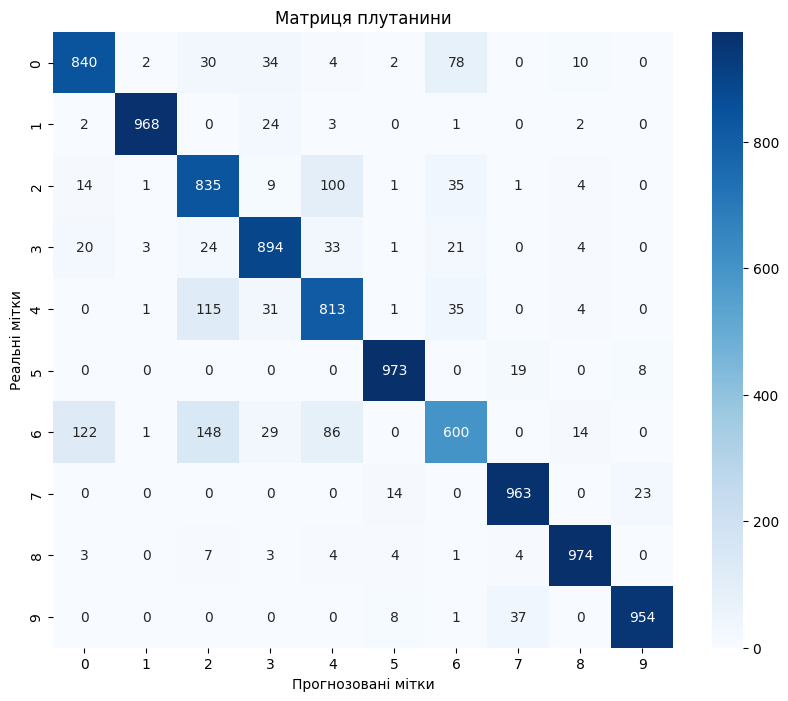

In [ ]:
# Створення матриці плутанини
# confusion_matrix приймає два аргументи:
# 1. test_labels: реальні мітки класів (правильні відповіді).
# 2. predicted_labels: прогнозовані мітки класів (результати роботи моделі).
# Результат — це матриця, де:
# - Рядки відповідають реальним міткам.
# - Стовпці відповідають прогнозованим міткам.
# - Значення в комірках показують кількість зображень, які належать до певного реального класу та були класифіковані як певний прогнозований клас.
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Візуалізація матриці плутанини
# Створюємо нове вікно для графіка з розміром 10x8 дюймів.
plt.figure(figsize=(10, 8))

# Використовуємо seaborn.heatmap для візуалізації матриці плутанини.
# Параметри:
# - conf_matrix: матриця плутанини, яку ми створили.
# - annot=True: додає числа в комірки матриці.
# - fmt='d': форматує числа як цілі (наприклад, 850, 10, тощо).
# - cmap='Blues': використовує синю кольорову схему для візуалізації.
# - xticklabels=range(10): підписи для стовпців (прогнозовані мітки) від 0 до 9.
# - yticklabels=range(10): підписи для рядків (реальні мітки) від 0 до 9.
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

# Додаємо підписи до осей:
# - Вісь X: "Прогнозовані мітки".
# - Вісь Y: "Реальні мітки".
plt.xlabel('Прогнозовані мітки')
plt.ylabel('Реальні мітки')

# Додаємо заголовок до графіка.
plt.title('Матриця плутанини')

# Відображаємо графік.
plt.show()

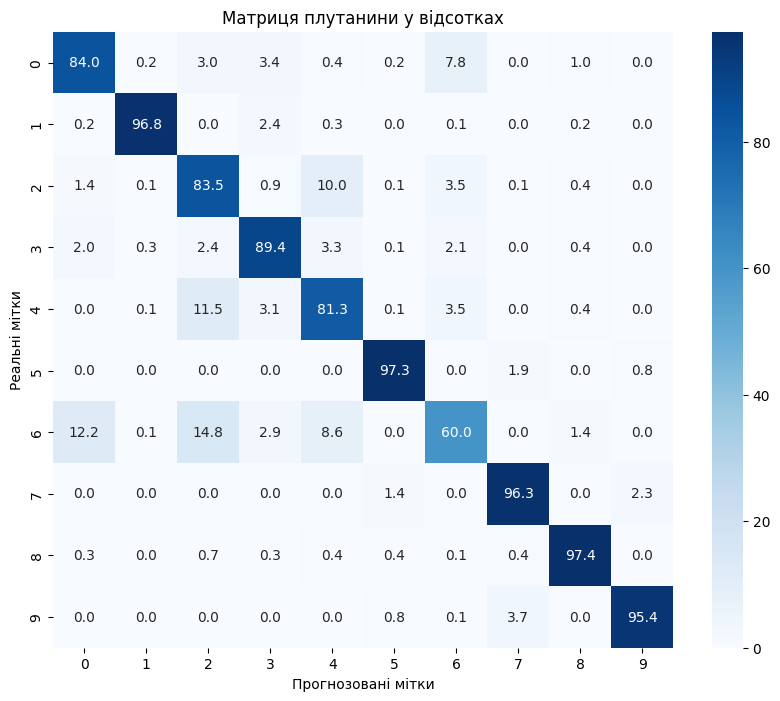

In [ ]:
# Створення матриці плутанини
# confusion_matrix приймає два аргументи:
# 1. test_labels: реальні мітки класів (правильні відповіді).
# 2. predicted_labels: прогнозовані мітки класів (результати роботи моделі).
# Результат — це матриця, де:
# - Рядки відповідають реальним міткам.
# - Стовпці відповідають прогнозованим міткам.
# - Значення в комірках показують кількість зображень, які належать до певного реального класу та були класифіковані як певний прогнозований клас.
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Нормалізація матриці плутанини у відсотках
# Для цього кожен елемент матриці ділиться на суму рядка (кількість зображень у реальному класі) і множиться на 100.
# Кроки:
# 1. conf_matrix.astype('float'): Перетворюємо матрицю у тип float, щоб уникнути цілочисельного ділення.
# 2. conf_matrix.sum(axis=1): Обчислюємо суму кожного рядка (кількість зображень у кожному реальному класі).
# 3. [:, np.newaxis]: Додаємо новий вимір для правильного ділення (перетворюємо вектор у стовпець).
# 4. * 100: Перетворюємо значення у відсотки.
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Візуалізація матриці плутанини у відсотках
# Створюємо нове вікно для графіка з розміром 10x8 дюймів.
plt.figure(figsize=(10, 8))

# Використовуємо seaborn.heatmap для візуалізації матриці плутанини.
# Параметри:
# - conf_matrix_percent: нормалізована матриця плутанини у відсотках.
# - annot=True: додає числа в комірки матриці.
# - fmt='.1f': форматує числа з одним знаком після коми (наприклад, 85.5, 10.0, тощо).
# - cmap='Blues': використовує синю кольорову схему для візуалізації.
# - xticklabels=range(10): підписи для стовпців (прогнозовані мітки) від 0 до 9.
# - yticklabels=range(10): підписи для рядків (реальні мітки) від 0 до 9.
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

# Додаємо підписи до осей:
# - Вісь X: "Прогнозовані мітки".
# - Вісь Y: "Реальні мітки".
plt.xlabel('Прогнозовані мітки')
plt.ylabel('Реальні мітки')

# Додаємо заголовок до графіка.
plt.title('Матриця плутанини у відсотках')

# Відображаємо графік.
plt.show()

## Додаткові тести із Модель #5

In [ ]:
# Функція для відображення зображення та передбаченої мітки
def plot_image(i, predictions_array, true_label, img):
    # Отримуємо справжню мітку і зображення по індексу
    true_label, img = true_label[i], img[i]

    # Вимикаємо сітку, відсутні мітки на осях
    plt.grid(False)
    plt.xticks([])  # Вимикаємо підписи по осі X
    plt.yticks([])  # Вимикаємо підписи по осі Y

    # Виводимо зображення у чорно-білому кольорі
    plt.imshow(img, cmap=plt.cm.binary)

    # Отримуємо індекс передбаченого класу з масиву ймовірностей
    predicted_label = np.argmax(predictions_array)

    # Встановлюємо колір залежно від того, чи правильний прогноз
    if predicted_label == true_label:
        color = 'blue'  # Якщо передбачення правильне, колір синій
    else:
        color = 'red'   # Якщо передбачення неправильне, колір червоний

    # Виводимо текст з класом, ймовірністю та реальною міткою під зображенням
    plt.xlabel("{} {:2.0f}% ({})".format(
        class_names[predicted_label],  # Назва передбаченого класу
        100*np.max(predictions_array),  # Ймовірність передбаченого класу
        class_names[true_label]  # Реальний клас
    ), color=color)

# Функція для відображення графіка з ймовірностями передбачень
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]

    # Вимикаємо сітку, відсутні мітки на осях
    plt.grid(False)
    plt.xticks(range(10))  # Підписи для всіх 10 класів
    plt.yticks([])  # Вимикаємо підписи по осі Y

    # Створюємо графік барів, що відображає ймовірності для кожного класу
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])  # Встановлюємо діапазон для осі Y від 0 до 1

    # Отримуємо індекс передбаченого класу
    predicted_label = np.argmax(predictions_array)

    # Змінюємо колір для бару передбаченого класу на червоний
    thisplot[predicted_label].set_color('red')
    # Змінюємо колір для бару реального класу на синій
    thisplot[true_label].set_color('blue')

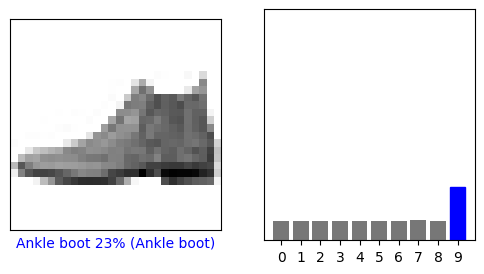

In [ ]:
# Перевіркиа прогнозів навченої моделі на тестовому наборі зображень.
# Для кожного зображення з тестового набору виводяться:
# 1. Саме зображення з прогнозом моделі (синій колір позначає правильний клас, червоний — передбачений клас).
# 2. Графік, що показує ймовірності для кожного з 10 класів,
# де червоний колір позначає клас, який був передбачений моделлю, а синій — правильний клас.

# Встановлюємо індекс зображення, яке будемо перевіряти
i = 0  # Ми вибираємо перше зображення з тестового набору для перевірки прогнозів.

# Створюємо фігуру для відображення зображення та графіку з ймовірностями
plt.figure(figsize=(6,3))  # Створюємо фігуру розміром 6x3 дюйма для двох підграфіків.

# Вставляємо перший підграфік, який показує саме зображення з прогнозом та правильною міткою
plt.subplot(1,2,1)  # 1 рядок, 2 стовпці, перший підграфік — зображення.
plot_image(i, predictions[i], test_labels, test_images)  # Виводимо перше зображення разом із прогнозом моделі.

# Вставляємо другий підграфік, який показує ймовірності для кожного класу
plt.subplot(1,2,2)  # 1 рядок, 2 стовпці, другий підграфік — графік ймовірностей класів.
plot_value_array(i, predictions[i], test_labels)  # Виводимо графік ймовірностей для кожного класу.

# Виводимо фігуру з двома підграфіками: зображенням та графіком ймовірностей
plt.show()  # Виводимо фігуру, що складається з двох підграфіків: зображення та ймовірностей.

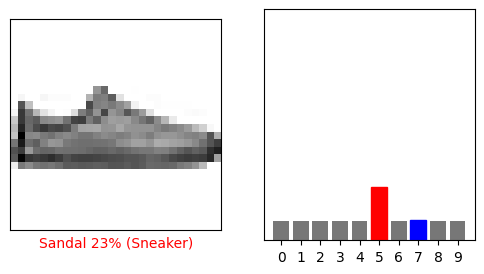

In [ ]:
# Встановлюємо індекс зображення, яке будемо перевіряти (12-те зображення з тестового набору)
i = 12  # Вибираємо зображення з індексом 12 для перевірки прогнозів.

# Створюємо фігуру розміром 6x3 дюйма для двох підграфіків
plt.figure(figsize=(6,3))  # Налаштовуємо розмір фігури для двох підграфіків: зображення та графіку ймовірностей.

# Вставляємо перший підграфік, який показує саме зображення з прогнозом та правильною міткою
plt.subplot(1,2,1)  # 1 рядок, 2 стовпці, перший підграфік — зображення.
plot_image(i, predictions[i], test_labels, test_images)  # Виводимо 12-те зображення разом із прогнозом моделі.

# Вставляємо другий підграфік, який показує ймовірності для кожного класу
plt.subplot(1,2,2)  # 1 рядок, 2 стовпці, другий підграфік — графік ймовірностей класів.
plot_value_array(i, predictions[i], test_labels)  # Виводимо графік ймовірностей для кожного класу.

# Виводимо фігуру з двома підграфіками: зображенням та графіком ймовірностей
plt.show()  # Виводимо фігуру, що складається з двох підграфіків: зображення та ймовірностей.

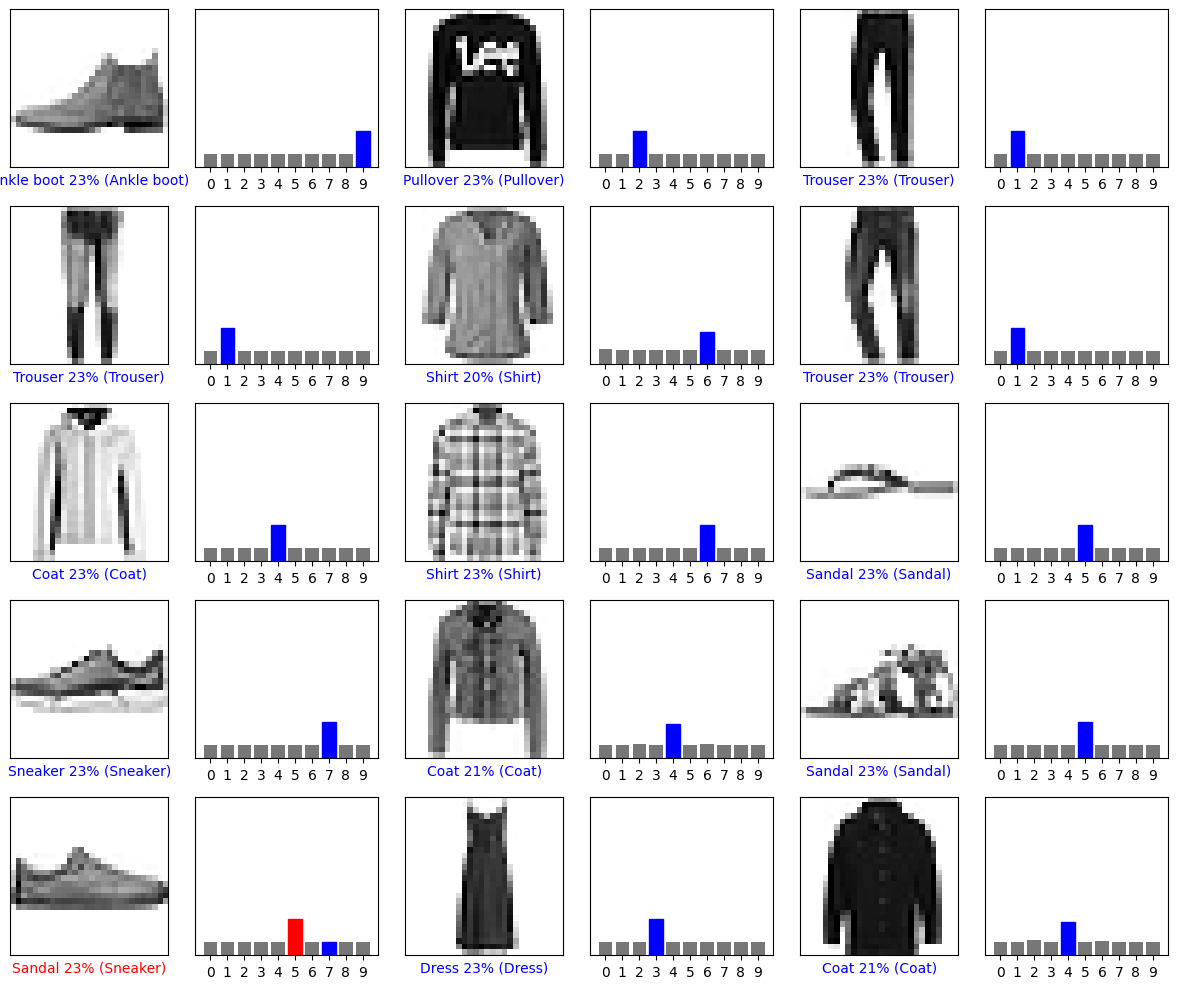

In [ ]:
# Побудуємо кілька зображень з їх передбаченнями. Зверніть увагу, що модель може помилятися, навіть якщо вона дуже впевнена.
# Виведемо перші X зображень з тестового набору, їх передбачувані мітки та правильні мітки.
# Правильні передбачення будуть позначені синім кольором, неправильні — червоним.

num_rows = 5  # Вказуємо кількість рядків для відображення зображень
num_cols = 3  # Вказуємо кількість стовпців для відображення зображень
num_images = num_rows * num_cols  # Загальна кількість зображень для відображення

# Налаштовуємо фігуру для графіків, встановлюючи розміри для всіх зображень
plt.figure(figsize=(2*2*num_cols, 2*num_rows))  # Ширина 2x для кожного стовпця, висота — для всіх рядків

# Перебираємо кожне зображення, щоб відобразити його та відповідні ймовірності
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)  # Визначаємо підграфік для зображення (ліворуч)
    plot_image(i, predictions[i], test_labels, test_images)  # Виводимо зображення з передбаченням

    plt.subplot(num_rows, 2*num_cols, 2*i+2)  # Визначаємо підграфік для графіка ймовірностей (праворуч)
    plot_value_array(i, predictions[i], test_labels)  # Виводимо графік ймовірностей для кожного класу

plt.tight_layout()  # Підганяємо макет, щоб усі графіки помістилися в межах фігури
plt.show()  # Виводимо фігуру з зображеннями та графіками ймовірностей

In [ ]:
# Використання навченої моделі для прогнозування одного зображення з тестового набору.
# Це дозволяє перевірити, як модель працює з конкретним зображенням та його передбаченим класом.

# Отримуємо зображення з тестового набору даних.
img = test_images[1]  # Вибираємо перше зображення з тестового набору (індексація починається з 0)

# Перевіряємо форму вибраного зображення, щоб переконатися, що воно має правильний формат.
print(img.shape)  # Має вивести (28, 28), тому що кожне зображення в тестовому наборі має розмір 28x28 пікселів

(28, 28)


In [ ]:
# Моделі tf.keras оптимізовані для роботи з пакетами (батчами) даних, а не з окремими прикладами.
# Тому, навіть якщо ми робимо прогноз тільки для одного зображення, потрібно додати його до "батча".
# Це здійснюється за допомогою np.expand_dims, щоб додати додаткову розмірність і створити батч,
# що містить лише одне зображення.

# Додаємо зображення в батч, де воно є єдиним елементом.
img = (np.expand_dims(img, 0))

# Перевіряємо форму зображення після додавання в батч.
print(img.shape)  # Тепер має бути (1, 28, 28), де 1 - це розмір батча (тобто одне зображення)

(1, 28, 28)


In [ ]:
# Тепер, коли зображення перетворено на батч (що містить лише одне зображення),
# можна використовувати модель для передбачення метки цього зображення.
# Ми будемо використовувати модель, яка містить шар softmax, щоб отримати ймовірності для кожного класу.

# Прогнозуємо клас для одного зображення (з батча).
predictions_single = probability_model.predict(img)

# Виводимо прогноз (масив ймовірностей для кожного з 10 класів).
print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.08553024 0.08551753 0.22908758 0.08551867 0.08645508 0.08551757
  0.0858205  0.08551747 0.08551785 0.08551748]]


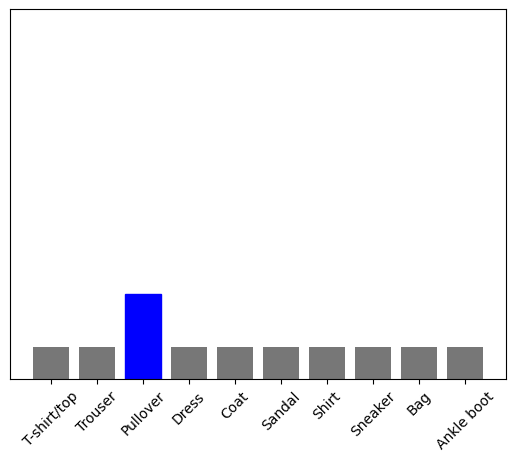

In [ ]:
# Відображаємо графік ймовірностей для кожного класу.
# Використовуємо функцію plot_value_array для побудови бар-графіка ймовірностей для кожного класу.

# Візуалізація значень ймовірностей для прогнозу одного зображення
plot_value_array(1, predictions_single[0], test_labels)

# Встановлюємо підписи до осі x, що представляють назви класів.
# Поворот підписів для кращої видимості.
_ = plt.xticks(range(10), class_names, rotation=45)

# Показуємо графік.
plt.show()

In [ ]:
# Для отримання індексу класу з найбільшою ймовірністю з прогнозу для одного зображення
predicted_class = np.argmax(predictions_single[0])

# Виведемо індекс класу з найбільшою ймовірністю
print(predicted_class)

2


## Висновки

У рамках домашнього завдання я створив нейронну мережу для класифікації зображень з датасету Fashion MNIST, досягнувши точності 92.2%, що перевищує мінімальний поріг 91%.

Основні етапи:

- Підготовка даних: завантаження, нормалізація, додавання каналу для згорткових шарів.
- Аугментація даних: горизонтальне віддзеркалення, випадкові повороти та масштабування.
- Архітектура моделі: два згорткові шари, шари нормалізації, підвибірки, регуляризації та повнозв'язні шари.
- Оптимізація: оптимізатор AdamW, функція втрат sparse_categorical_crossentropy, callback-и ReduceLROnPlateau та EarlyStopping.
- Навчання: 50 епох, розмір батчу 128, валідація.
- Результати: точність на тестах 92.2%, що підтверджує ефективність моделі.

Висновки:

- Згорткові шари ефективно виявляють особливості зображень.
- Аугментація покращує узагальнення моделі.
- Оптимізатор AdamW із регуляризацією добре працює для навчання.
- Подальші покращення можуть включати глибші архітектури, складнішу аугментацію та інші оптимізатори.

Підсумок: модель досягла точності 91.61%, що підтверджує ефективність вибраних підходів.